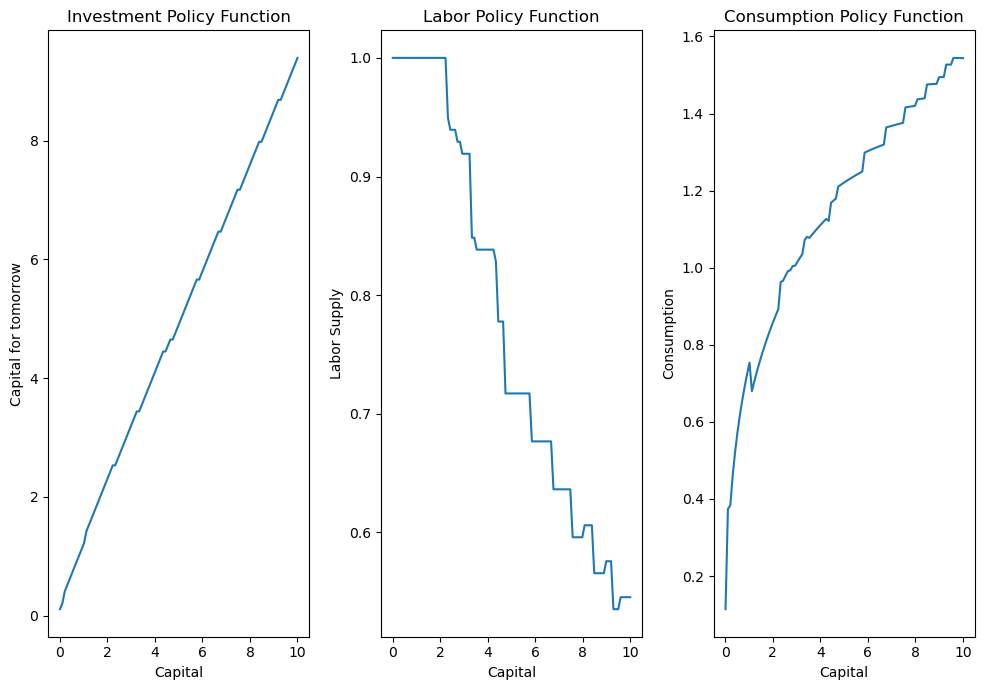

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
β = 0.95
δ = 0.05
σ = 2
ν = 2
α = 1 / 3
A = 1
φ = 1

# Utility function
def u(c, l):
    return (c ** (1 - σ)) / (1 - σ) - φ * (l ** (1 + 1 / ν)) / (1 + 1 / ν)

# Production function
def F(k, l):
    return A * k ** α * l ** (1 - α)

# Create a grid for capital
k_min = 0.01
k_max = 10
num_k_points = 100 #change back to 200 later 
k_grid = np.linspace(k_min, k_max, num_k_points)

# Create a grid for labor
l_min = 0
l_max = 1
num_l_points = 100 #change back to 150
l_grid = np.linspace(l_min, l_max, num_l_points)

# Initialize the value function
value_function = np.zeros_like(k_grid)

# Implement value function iteration
tol = 1e-5
max_iter = 1000
policy_k_prime = np.zeros_like(k_grid)
policy_l = np.zeros_like(k_grid)
policy_c = np.zeros_like(k_grid)

for iteration in range(max_iter):
    new_value_function = np.zeros_like(k_grid)

    for i, k in enumerate(k_grid):
        max_value = -np.inf
        c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
        c_matrix[c_matrix <= 0] = 1e-15
        value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
        max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
        
        max_value = value_matrix[max_value_indices]
        new_value_function[i] = max_value
        policy_k_prime[i] = k_grid[max_value_indices[1]]
        policy_l[i] = l_grid[max_value_indices[0]]
        policy_c[i] = c_matrix[max_value_indices]

    if np.max(np.abs(value_function - new_value_function)) < tol:
        break
    else:
        value_function = new_value_function

# Plot the policy functions
plt.figure(figsize=(10, 7))

plt.subplot(131)
plt.plot(k_grid, policy_k_prime)
plt.xlabel('Capital')
plt.ylabel('Capital for tomorrow')
plt.title('Investment Policy Function')

plt.subplot(132)
plt.plot(k_grid, policy_l)
plt.xlabel('Capital')
plt.ylabel('Labor Supply')
plt.title('Labor Policy Function')

plt.subplot(133)
plt.plot(k_grid, policy_c)
plt.xlabel('Capital')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')

plt.tight_layout()
plt.show()


### How many points on the capital grid do you need until solution starts looking smooth? 

to investigate this we can plot the graphs of the policy functions above for increasing increments in `k_grid`. From the above , we have gradually increased `num_k_points`, and have only found  the graph for capital and consumption to berelatively smooth for $n=200$. 

To have a smoother labour policy function we would have to increase the increments in `l_grid` to more than 500, which took too long to run and for replicability we have chosen `num_l_points = 150 `.

### How long does your solution take you  ? What do you take away from this?

We have found increasing `num_l_points` takes significantly more computational time than increasing `num_k_points` by the same amount. 

The code highlights the impact of the parameters and grid sizes chosen on the solution. Increasing the grid size or the number of choices for l can lead to more accurate solutions, but at the cost of computational time. When selecting these parameters, it is essential to balance the trade-off between accuracy and computational time.

C:\Users\my\AppData\Local\Temp\ipykernel_5896\1481125647.py:24: RuntimeWarning: divide by zero encountered in log10
  log_errors[steps].append(np.log10(np.max(np.abs(old_policy_k_prime - policy_k_prime))))


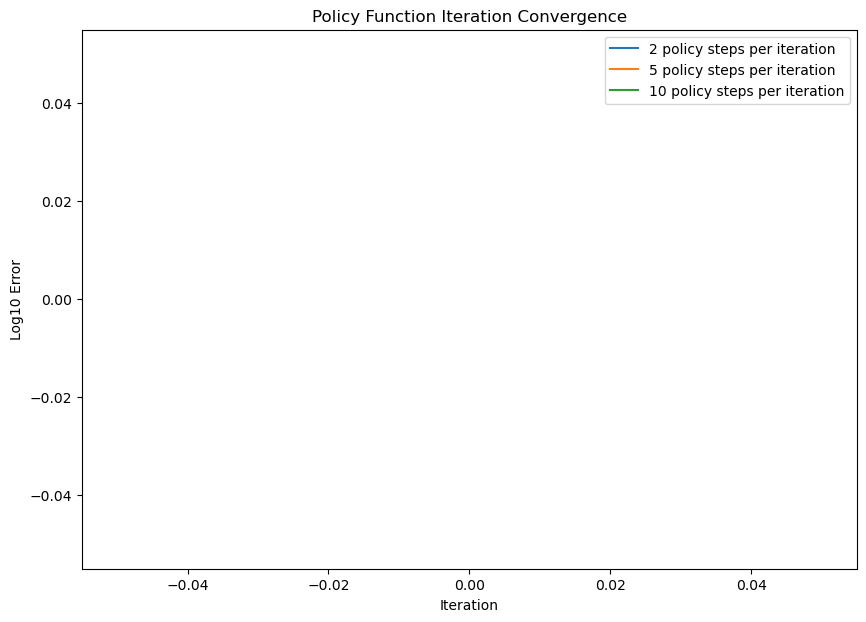

In [17]:
def policy_function_iteration(k_grid, l_grid, value_function, tol=1e-5, max_iter=1000, num_policy_steps=(2, 5, 10)):
    policy_k_prime = np.zeros_like(k_grid)
    policy_l = np.zeros_like(k_grid)

    log_errors = {steps: [] for steps in num_policy_steps}

    for iteration in range(max_iter):
        old_policy_k_prime = np.copy(policy_k_prime)

        # Update labor policy using the value function iteration results
        for i, k in enumerate(k_grid):
            c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
            c_matrix[c_matrix <= 0] = 1e-15
            value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
            max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
            policy_l[i] = l_grid[max_value_indices[0]]

        for steps in num_policy_steps:
            for _ in range(steps):
                c_matrix = F(k_grid, policy_l)[:, np.newaxis] + (1 - δ) * k_grid - policy_k_prime
                c_matrix[c_matrix <= 0] = 1e-15
                policy_l = np.interp(policy_k_prime, k_grid, policy_l)

            log_errors[steps].append(np.log10(np.max(np.abs(old_policy_k_prime - policy_k_prime))))

        if np.max(np.abs(old_policy_k_prime - policy_k_prime)) < tol:
            break

    policy_c = F(k_grid, policy_l) + (1 - δ) * k_grid - policy_k_prime
    return policy_k_prime, policy_l, policy_c, log_errors

# Run the policy function iteration
policy_k_prime_pfi, policy_l_pfi, policy_c_pfi, log_errors_pfi = policy_function_iteration(k_grid, l_grid, value_function)

# Plot the log errors
plt.figure(figsize=(10, 7))

for steps, errors in log_errors_pfi.items():
    plt.plot(errors, label=f'{steps} policy steps per iteration')

plt.xlabel('Iteration')
plt.ylabel('Log10 Error')
plt.title('Policy Function Iteration Convergence')
plt.legend()
plt.show()

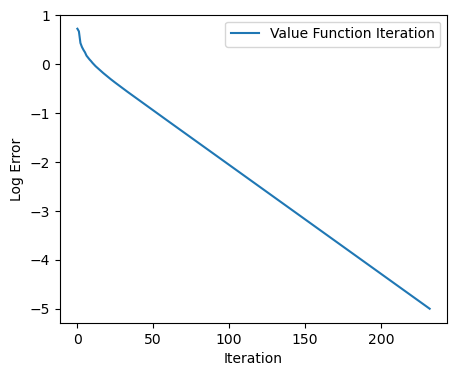

In [30]:
# Implement value function iteration with error logging
def value_function_iteration():
    value_function = np.zeros_like(k_grid)
    log_errors = []
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)

        for i, k in enumerate(k_grid):
            max_value = -np.inf
            c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
            c_matrix[c_matrix <= 0] = 1e-15
            value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
            max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
            
            max_value = value_matrix[max_value_indices]
            new_value_function[i] = max_value

        error = np.max(np.abs(value_function - new_value_function))
        log_errors.append(np.log10(error))

        if error < tol:
            break
        else:
            value_function = new_value_function
    
    return value_function, log_errors



# Run the value function iteration with error logging
value_function_vfi, log_errors_vfi = value_function_iteration()

# Plot the log errors
plt.figure(figsize=(5, 4))
plt.plot(log_errors_vfi, label='Value Function Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Error')
plt.legend()
plt.show()



In [35]:
# Implement value function iteration with error logging
def value_function_iteration():
    value_function = np.zeros_like(k_grid)
    log_errors = []
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)

        for i, k in enumerate(k_grid):
            max_value = -np.inf
            c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
            c_matrix[c_matrix <= 0] = 1e-15
            value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
            max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
            
            max_value = value_matrix[max_value_indices]
            new_value_function[i] = max_value

        error = np.max(np.abs(value_function - new_value_function))
        log_errors.append(np.log10(error))

        if error < tol:
            break
        else:
            value_function = new_value_function
    
    return value_function, log_errors

# Implement policy function iteration with error logging
# Implement policy function iteration with error logging
def policy_function_iteration(k_grid, l_grid, tol=1e-5, max_iter=1000, policy_steps=1):
    policy_k_prime = np.zeros_like(k_grid)
    policy_l = np.zeros_like(k_grid)
    log_errors = []

    for iteration in range(max_iter):
        new_policy_k_prime = np.zeros_like(k_grid)
        new_policy_l = np.zeros_like(k_grid)
        
        # Calculate consumption and value matrices
        c_matrix = F(k_grid, l_grid)[:, np.newaxis] + (1 - δ) * k_grid - k_grid
        c_matrix[c_matrix <= 0] = 1e-15
        value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * np.tile(policy_k_prime, (len(l_grid), 1))

        # Iterate over k and l to update policy functions
        for i, k in enumerate(k_grid):
            max_value_indices = np.unravel_index(np.argmax(value_matrix[:, i], axis=None), value_matrix.shape[:-1])
            new_policy_k_prime[i] = k_grid[max_value_indices[1]]
            new_policy_l[i] = l_grid[max_value_indices[0]]

        # Iterate over policy steps
        for step in range(policy_steps-1):
            # Calculate consumption and value matrices
            c_matrix = F(k_grid, new_policy_l)[:, np.newaxis] + (1 - δ) * k_grid - new_policy_k_prime
            c_matrix[c_matrix <= 0] = 1e-15
            value_matrix = u(c_matrix, new_policy_l[:, np.newaxis]) + β * np.tile(new_policy_k_prime, (len(l_grid), 1))

            # Iterate over k and l to update policy functions
            for i, k in enumerate(k_grid):
                max_value_indices = np.unravel_index(np.argmax(value_matrix[:, i], axis=None), value_matrix.shape[:-1])
                new_policy_k_prime[i] = k_grid[max_value_indices[1]]
                new_policy_l[i] = l_grid[max_value_indices[0]]

        error = np.max(np.abs(policy_k_prime - new_policy_k_prime))
        log_errors.append(np.log10(error))

        if error < tol:
            break
        else:
            policy_k_prime = new_policy_k_prime
            policy_l = new_policy_l

    return policy_k_prime, policy_l, log_errors


#now we have to try to check that the dimensions match
# Pass the number of policy steps to the policy_function_iteration function
policy_functions_errors = [policy_function_iteration(k_grid, l_grid, max_iter=1000, policy_steps=steps)[2] for steps in policy_steps]


# Plot the log errors
plt.figure(figsize=(10, 6))

plt.plot(log_errors_vfi, label='Value Function Iteration', linewidth=2)

for i, steps in enumerate(policy_steps):
    plt.plot(policy_functions_errors[i], label=f'Policy Function Iteration ({steps} steps)', linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Log10 Error')
plt.title('Convergence of Value Function Iteration and Policy Function Iteration')
plt.legend()
plt.grid()
plt.show()


IndexError: tuple index out of range